# Breast Cancer Detection with VGG16

# Importing Libraries and Tools

In [97]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import keras
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
%matplotlib inline

# Loading the Dataset (Images)

In [98]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('E:/Breast Cancer_train/Bening',224))
malign_train = np.array(Dataset_loader('E:/Breast Cancer_train/Malignant',224))
benign_test = np.array(Dataset_loader('E:/Breast Cancer_Test/Bening',224))
malign_test = np.array(Dataset_loader('E:/Breast Cancer_Test/Malignant',224))

100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:01<00:00, 56.74it/s]


# Dataset Processing

In [99]:
# Dataset shuffling and converting into categorical format

benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Dataset Spliting

In [100]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)



# Data Visualization

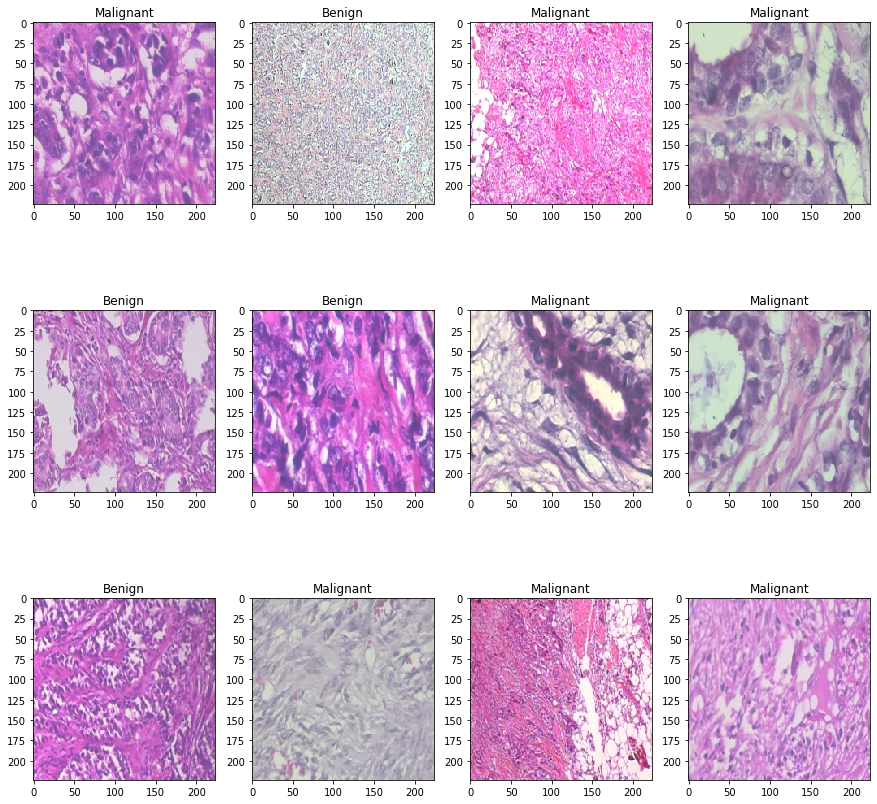

In [101]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# VGG16 via Transfer Learning

In [102]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [103]:
vgg16 = VGG16(include_top=False, 
              weights='imagenet', 
              input_shape=(224,224,3))

In [104]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [105]:
for layers in vgg16.layers:
    layers.trainable = False

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [107]:
X = Flatten()(vgg16.output)

In [110]:
fcc_layer   = Dense(units = 1024, activation = 'relu')(X)
Final_layer = Dense(units = 2, activation = 'sigmoid')(fcc_layer)

In [112]:
model = Model(inputs = vgg16.input, outputs = Final_layer)

In [113]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [45]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Model Training

In [46]:
history = model.fit(x_train, y_train, batch_size=32, epochs=8, 
                 validation_data=(x_val, y_val))

Train on 1461 samples, validate on 366 samples
Epoch 1/8
1461/1461 [==============================] - 584s 400ms/sample - loss: 10.3219 - acc: 0.8563 - val_loss: 1.0238 - val_acc: 0.9126
Epoch 2/8
1461/1461 [==============================] - 593s 406ms/sample - loss: 0.0964 - acc: 0.9784 - val_loss: 0.7093 - val_acc: 0.9126
Epoch 3/8
1461/1461 [==============================] - 588s 402ms/sample - loss: 0.0160 - acc: 0.9962 - val_loss: 0.7123 - val_acc: 0.9194
Epoch 4/8
1461/1461 [==============================] - 586s 401ms/sample - loss: 7.7679e-04 - acc: 1.0000 - val_loss: 0.7535 - val_acc: 0.9126
Epoch 5/8
1461/1461 [==============================] - 578s 396ms/sample - loss: 1.7508e-04 - acc: 1.0000 - val_loss: 0.7589 - val_acc: 0.9126
Epoch 6/8
1461/1461 [==============================] - 579s 396ms/sample - loss: 8.2651e-05 - acc: 1.0000 - val_loss: 0.7585 - val_acc: 0.9139
Epoch 7/8
1461/1461 [==============================] - 604s 414ms/sample - loss: 7.0710e-05 - acc: 1.0000 

# Model Evaluation

In [50]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

199/199 [==============================] - 60s 304ms/sample - loss: 2.1835 - acc: 0.9045
Loss = 2.1835379921290796
Test Accuracy = 0.9045226


In [52]:
Y_val_pred = model.predict(x_val)

# Evaluating Confusion Marix

In [54]:
Y_pred = model.predict(X_test)

In [61]:
BATCH_SIZE = 16
import gc
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [62]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:26<00:00, 68.70s/it]


In [63]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

In [64]:
print(cm)

[[106   1]
 [ 18  74]]


# Classification Report

In [66]:
from sklearn.metrics import classification_report
clfreport = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
print("Classification Report")
print(clfreport)   

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       107
           1       0.99      0.80      0.89        92

    accuracy                           0.90       199
   macro avg       0.92      0.90      0.90       199
weighted avg       0.92      0.90      0.90       199

